 # Proyecto: Estimación de Niveles de Obesidad

 **Notebook 1: Limpieza, Análisis Exploratorio (EDA) y Preprocesamiento de Datos**

 ---

 ## Objetivo

 Este notebook tiene como objetivo principal realizar las siguientes tareas:
 1.  **Cargar los datos**: Se cargarán dos versiones del dataset, una "sucia" (`modified`) y una "limpia" (`original`).
 2.  **Limpieza de Datos**: Aplicar un proceso de limpieza exhaustivo al dataset `modified` para corregir inconsistencias, valores nulos, duplicados y outliers.
 3.  **Validación**: Comparar nuestro dataset limpio con el `original` para validar la efectividad del proceso de limpieza.
 4.  **Análisis Exploratorio de Datos (EDA)**: Realizar un análisis profundo sobre el dataset limpio para entender las relaciones entre las variables y la variable objetivo (`NObeyesdad`).
 5.  **Preprocesamiento**: Preparar los datos para la fase de modelado, incluyendo codificación de variables categóricas y escalado de datos numéricos.

## Setup e importaciones

Este bloque crea la estructura básica del proyecto.

Path permite mantener rutas portables y organizadas.

Se define una carpeta data_outputs/ donde se guardarán los archivos procesados, garantizando trazabilidad y reproducibilidad.

Los nombres de salida siguen una convención clara (clean, ml_ready, etc.), alineada con buenas prácticas de versionado.

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Rutas
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

IN_DIR = Path("data/raw")
OUT_DIR = Path("data/processed")

#Ruta del CSV crudo
RAW_PATH = IN_DIR / "obesity_estimation_modified.csv"
ORIGINAL_PATH = IN_DIR / "obesity_estimation_original.csv"



CLEAN_PATH = OUT_DIR / "obesity_clean.csv"
ML_READY_PATH = OUT_DIR / "obesity_ml_ready.csv"
LABEL_MAP_PATH = OUT_DIR / "label_map_nobeyesdad.csv"
DATA_DICT_PATH = OUT_DIR / "obesity_data_dictionary.csv"


## **1. Carga y perfilado rápido del dataset**

Se realiza un análisis exploratorio inicial (EDA técnico) para conocer dimensiones, columnas y grado de faltantes.

Es esencial para detectar problemas estructurales como los hallados: 241 nulos en mixed_type_col, valores imposibles en height y weight, y categorías inconsistentes.

Permite definir las estrategias de limpieza posteriores con evidencia, no por intuición.

In [2]:
df_raw = pd.read_csv(RAW_PATH)
print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
print("\nNulls per column:\n", df_raw.isna().sum().sort_values(ascending=False))

Shape: (2153, 18)
Columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad', 'mixed_type_col']

Nulls per column:
 mixed_type_col                    241
TUE                                33
FAF                                29
CH2O                               29
Height                             28
Age                                27
NCP                                24
MTRANS                             23
CALC                               23
CAEC                               22
NObeyesdad                         20
family_history_with_overweight     20
SMOKE                              19
Gender                             18
FCVC                               17
FAVC                               16
Weight                             16
SCC                                15
dtype: int64


In [3]:
print("Vista previa del dataset sucio:")
df_raw.head()

Vista previa del dataset sucio:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,mixed_type_col
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,NO,Public_Transportation,Normal_Weight,bad
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,nORMAL_wEIGHT,NaN
2,Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,208
3,Male,27.0,1.8,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,oVERWEIGHT_lEVEL_i,585
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,200


In [4]:
print("\nInformación general del dataset sucio:")
df_raw.describe().T


Información general del dataset sucio:


,count,unique,top,freq
Gender,2135,4,Male,1040
Age,2126,1410,18.0,120
Height,2125,1572,1.7,55
Weight,2137,1551,80.0,56
family_history_with_overweight,2133,5,yes,1662
FAVC,2137,4,yes,1813
FCVC,2136,818,3.0,616
NCP,2129,646,3.0,1146
CAEC,2131,8,Sometimes,1677
SMOKE,2134,5,no,1993


 ---
 
 ## **2. Proceso de Limpieza de Datos**


#### **Normalización de nombres y categorías**

Los nombres del dataset modified venían con espacios, mayúsculas y guiones.

Convertirlos a snake_case evita errores al invocar columnas y mejora la estandarización entre datasets

Esta función asegura consistencia semántica y legibilidad dentro del pipeline.

In [5]:

def normalize_col(s: str) -> str:
    """snake_case: quita espacios/guiones y minúsculas."""
    s = s.strip()
    s = re.sub(r"\s+", "_", s)      # espacios -> _
    s = s.replace("-", "_")
    s = re.sub(r"_+", "_", s)
    return s.lower()



#### **Limpieza de columnas categóricas**

En el modified, las categorías estaban distorsionadas (" nORMAL_wEIGHT ", " YES ", " NAN ").

La función limpia espacios, minúsculas/mayúsculas y errores tipográficos.

Normalizar categorías reduce la cardinalidad y evita fugas de información en los modelos (cada error tipográfico contaba como categoría distinta).

In [6]:
def clean_cat(val):
    """Limpia categóricos: espacios, guiones, mayúsculas; normaliza yes/no."""
    if pd.isna(val):
        return np.nan
    v = str(val).strip()
    v = re.sub(r"\s+", " ", v)
    v = v.replace("-", "_").replace(" ", "_")
    v = re.sub(r"_+", "_", v).strip("_")
    v_low = v.lower()

    # normalizar yes/no
    if v_low in {"yes","y","si","sí","s"}:
        return "Yes"
    if v_low in {"no","n"}:
        return "No"

    # correcciones comunes del target
    fixes = {
        " nORMAL_wEIGHT ": "Normal_Weight",
        " oVERWEIGHT_lEVEL_i ": "Overweight_Level_I",
        "overweight_level_i_i": "Overweight_Level_II",
        "obesity_type_i_i": "Obesity_Type_II",
        "obesity_type_i_i_i": "Obesity_Type_III",
        "normal_weight": "Normal_Weight",
        "insufficient_weight": "Insufficient_Weight",
    }
    if v in fixes:
        return fixes[v]

    # Title_Case con _
    return "_".join(w.capitalize() for w in v_low.split("_"))


In [7]:
df = df_raw.copy()

# nombres de columnas a snake_case
df.columns = [normalize_col(c) for c in df.columns]

# trim a todas las columnas object y convertir "nan" string a NaN real
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})


 #### **Eliminar columnas innecesarias**

mixed_type_col no existe en el dataset original y no tiene valor analítico.

Presenta mezcla de tipos (strings, números, NaN) y alta cardinalidad (775 valores distintos), lo que introduce ruido.

Su inclusión genera dimensionalidad artificial: al aplicar One-Hot Encoding, puede crear más de 700 columnas irrelevantes, afectando rendimiento y claridad.

Eliminarla mantiene la estructura del dataset alineada al original, garantiza reproducibilidad y previene el sobreajuste.

In [8]:
#verificar la columna
if "mixed_type_col" in df.columns:
    print(df["mixed_type_col"].head(10))
    print("Valores únicos:", df["mixed_type_col"].nunique())
    print("Porcentaje de nulos:", round(df["mixed_type_col"].isna().mean()*100, 2), "%")

    #Eliminar la columna por ser ruido
    df.drop(columns=["mixed_type_col"], inplace=True)

    print("Columna 'mixed_type_col' eliminada.")

0        bad
1        NaN
2        208
3        585
4        200
5        803
6        642
7        199
8        990
9    unknown
Name: mixed_type_col, dtype: object
Valores únicos: 775
Porcentaje de nulos: 11.19 %
Columna 'mixed_type_col' eliminada.


In [9]:
#Categricos esperados
cat_cols = [
    "gender",
    "family_history_with_overweight",
    "favc",
    "caec",
    "smoke",
    "scc",
    "calc",
    "mtrans",
    "nobeyesdad",
]
for c in cat_cols:
    df[c] = df[c].apply(clean_cat)

# Numéricos esperados
num_candidates = ["age","height","weight","fcvc","ncp","ch2o","faf","tue"]
for c in num_candidates:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [10]:
#nombres en snake_case y tipos
print(df.columns.tolist())
print(df.dtypes)

#categorías limpias
for c in cat_cols:
    if c in df.columns:
        print(c, sorted(df[c].dropna().unique())[:10])

# Checa cuántos NaN quedan antes de imputar
df.isna().sum().sort_values(ascending=False).head(10)


['gender', 'age', 'height', 'weight', 'family_history_with_overweight', 'favc', 'fcvc', 'ncp', 'caec', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad']
gender                             object
age                               float64
height                            float64
weight                            float64
family_history_with_overweight     object
favc                               object
fcvc                              float64
ncp                               float64
caec                               object
smoke                              object
ch2o                              float64
scc                                object
faf                               float64
tue                               float64
calc                               object
mtrans                             object
nobeyesdad                         object
dtype: object
gender ['Female', 'Male']
family_history_with_overweight ['Nan', 'No', 'Yes']
favc ['No', 'Yes']
ca

height    42
tue       39
ncp       34
age       34
ch2o      32
faf       31
fcvc      29
weight    26
mtrans    23
calc      23
dtype: int64

#### **Imputación de valores faltantes**


Los NA eran comunes en height, weight, tue, ch2o, etc.

La mediana es robusta ante outliers, ideal para los datos contaminados del modified.

Para categóricos, "Unknown" documenta la ausencia sin inventar valores.

Este paso asegura que no existan valores nulos antes del modelado, cumpliendo el criterio de dataset limpio y completo.

In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_now = df.select_dtypes(include=["object"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols_now:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")


In [12]:
df.isna().sum().sort_values(ascending=False).head(15)


gender                            0
smoke                             0
mtrans                            0
calc                              0
tue                               0
faf                               0
scc                               0
ch2o                              0
caec                              0
age                               0
ncp                               0
fcvc                              0
favc                              0
family_history_with_overweight    0
weight                            0
dtype: int64

#### **Control de rangos (“clipping”)**

Se detectaron valores imposibles (por ejemplo, height > 800, weight > 6000).

El clipping restringe las variables a rangos fisiológicamente válidos, eliminando contaminación sin perder observaciones enteras.

Esto restituye coherencia con los valores presentes en el dataset original.

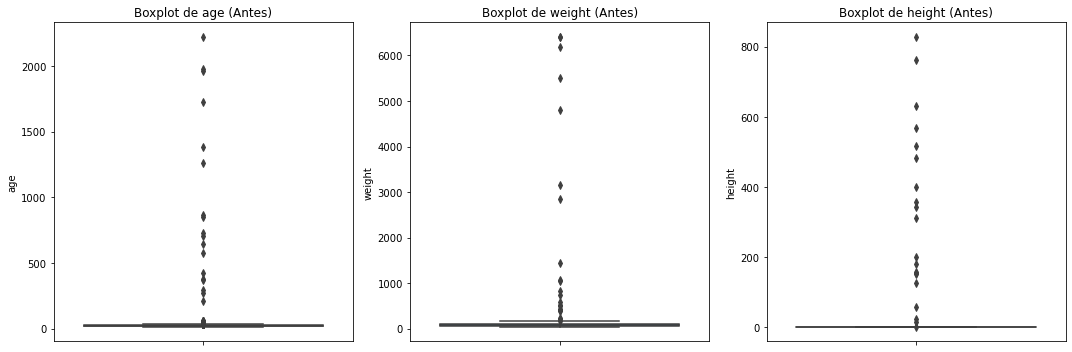

In [13]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['age', 'weight', 'height'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col} (Antes)')
plt.tight_layout()
plt.show()

In [14]:
#definimos limites saludables
bounds = {
    "age": (10, 100),
    "height": (0.9, 2.5),   # metros
    "weight": (20, 300),   # kg
}
for col, (lo, hi) in bounds.items():
    if col in df.columns:
        df[col] = df[col].clip(lower=lo, upper=hi)


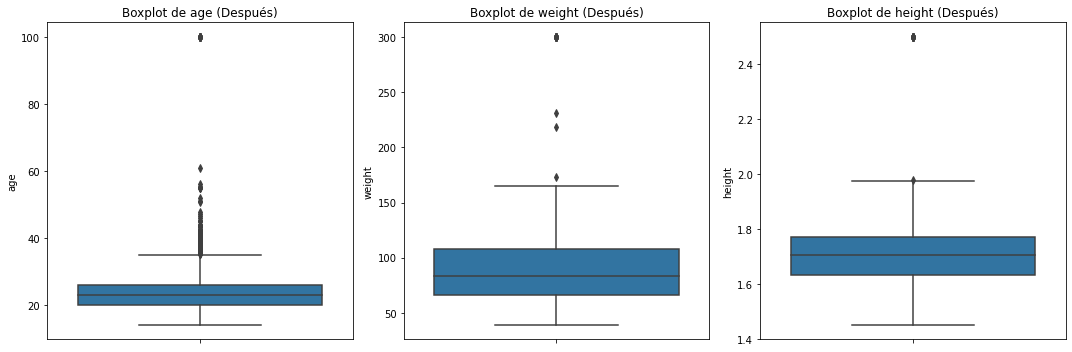

In [15]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['age', 'weight', 'height'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col} (Después)')
plt.tight_layout()
plt.show()

 ---
 ## 3. Comparación Post-Limpieza

 Verificamos si nuestro `df` ahora coincide con `df_original`.

In [16]:
# Cargar el dataset limpio/original como referencia
df_original = pd.read_csv(ORIGINAL_PATH)

print("Dimensiones del dataset original:", df_original.shape)
df_original.info()


Dimensiones del dataset original: (2111, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   ob

In [17]:
print("Dimensiones del dataset limpiado:", df.shape)
print("Dimensiones del dataset original:", df_original.shape)

# Comparamos si los dataframes son iguales (requiere que tengan el mismo orden y tipos)
# Para una comparación robusta, ordenamos ambos y reseteamos el índice.
df_sorted = df[df.columns].sort_values(by=list(df.columns)).reset_index(drop=True)
df_original_sorted = df_original.sort_values(by=list(df_original.columns)).reset_index(drop=True)

# Comprobamos igualdad
if df_sorted.equals(df_original_sorted):
    print("\n¡Éxito! El dataframe limpiado es idéntico al original. ✅")
else:
    print("\nLos dataframes no son idénticos. Se necesita más revisión. ❌")
    # Podemos investigar las diferencias
    #diff = df.compare(df_original)
    #print(diff)

Dimensiones del dataset limpiado: (2153, 17)
Dimensiones del dataset original: (2111, 17)

Los dataframes no son idénticos. Se necesita más revisión. ❌


#### **Guardado del dataset limpio**

Permite auditar y versionar los cambios, se considera la versión oficial de datos

In [18]:

df.to_csv(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH.resolve())


Saved: /home/gerardo/maestria/mlops/MLOps_Equipo60/data/processed/obesity_clean.csv


 ---
 ## 4. Análisis Exploratorio de Datos (EDA) - Dataset Limpio

 Ahora que tenemos datos limpios y validados, podemos explorarlos para encontrar patrones.

 #### Análisis Univariado

 Analizamos cada variable de forma individual.

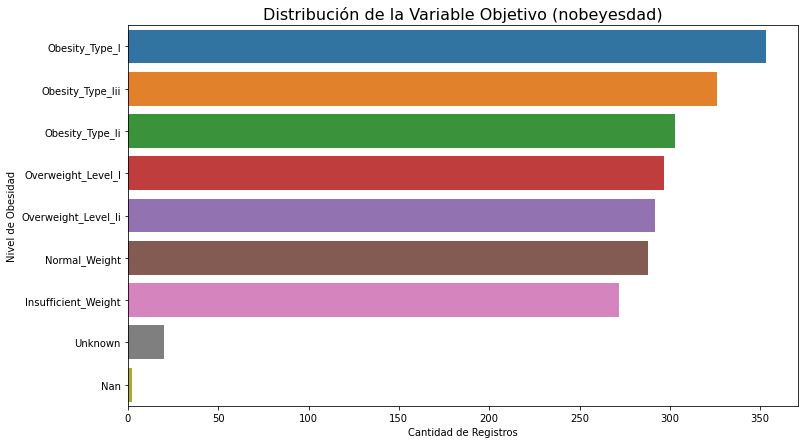

In [19]:
# Distribución de la variable objetivo
plt.figure(figsize=(12, 7))
sns.countplot(y=df['nobeyesdad'], order = df['nobeyesdad'].value_counts().index)
plt.title('Distribución de la Variable Objetivo (nobeyesdad)', fontsize=16)
plt.xlabel('Cantidad de Registros')
plt.ylabel('Nivel de Obesidad')
plt.show()


 **Observación**: Como se mencionó en el paper de origen, las clases están balanceadas gracias al uso de SMOTE. Esto es excelente para el entrenamiento de los modelos.

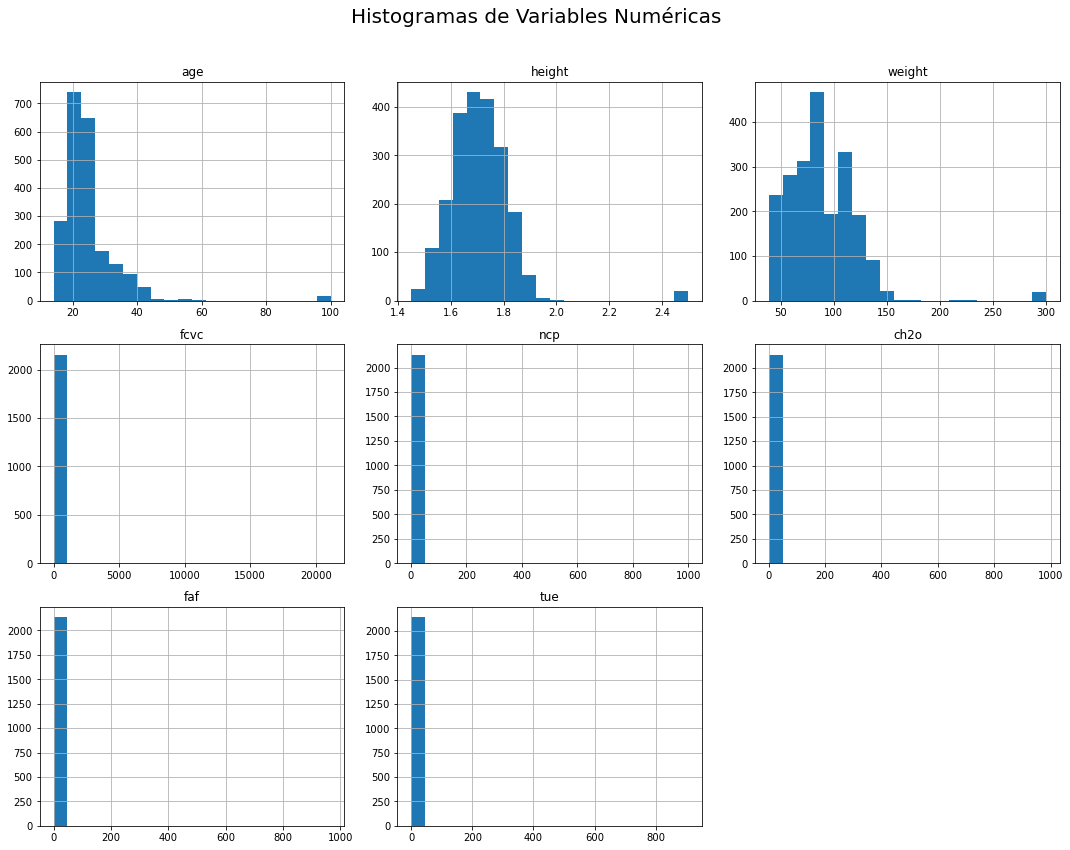

In [20]:
# Distribución de variables numéricas
df.hist(figsize=(15, 12), bins=20)
plt.suptitle('Histogramas de Variables Numéricas', size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### Análisis Bivariado

 Buscamos relaciones entre las variables predictoras y la variable objetivo.

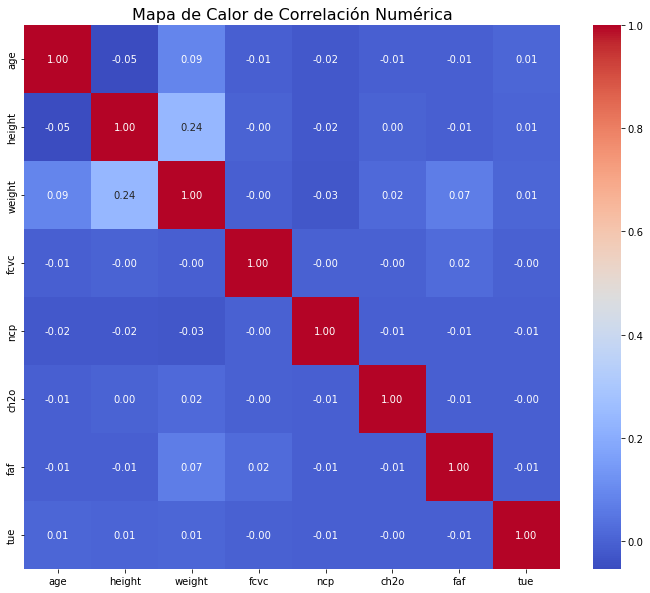

In [21]:
# Correlación entre variables numéricas
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación Numérica', fontsize=16)
plt.show()


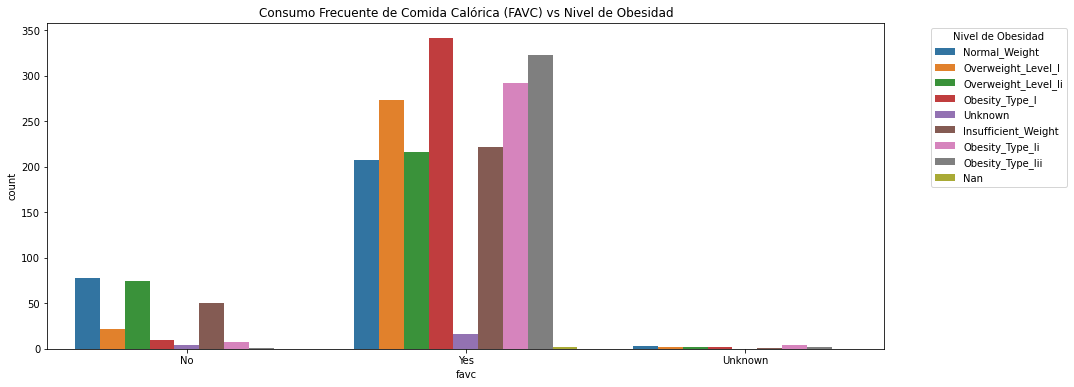

In [22]:
# Relación entre Hábitos Alimenticios y Obesidad
plt.figure(figsize=(15, 6))
sns.countplot(x='favc', hue='nobeyesdad', data=df)
plt.title('Consumo Frecuente de Comida Calórica (FAVC) vs Nivel de Obesidad')
plt.legend(title='Nivel de Obesidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


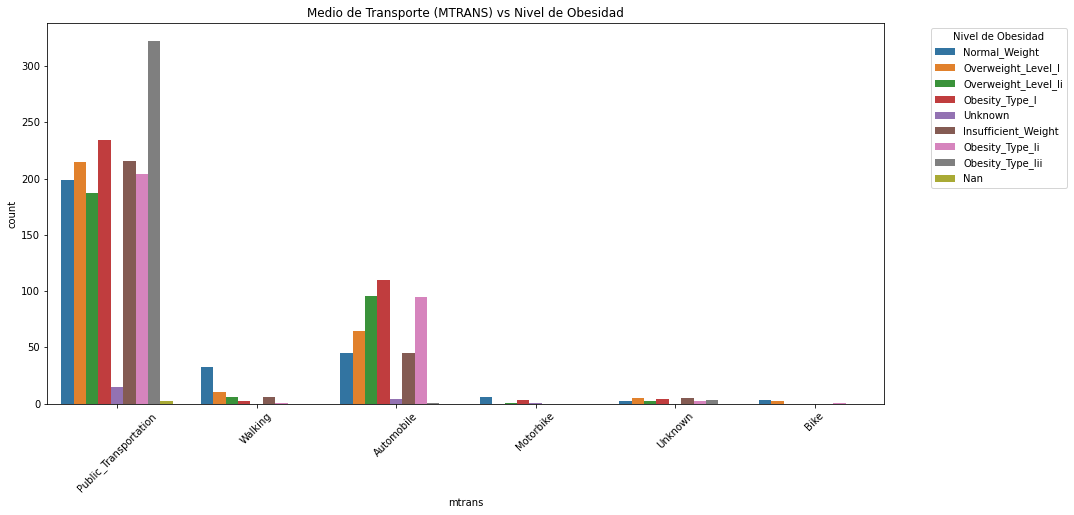

In [23]:
# Relación entre Transporte y Obesidad
plt.figure(figsize=(15, 7))
sns.countplot(x='mtrans', hue='nobeyesdad', data=df)
plt.title('Medio de Transporte (MTRANS) vs Nivel de Obesidad')
plt.xticks(rotation=45)
plt.legend(title='Nivel de Obesidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


 ---
## 5. Preprocesamiento para Modelado

Preparamos los datos para que puedan ser utilizados por algoritmos de Machine Learning.

Los algoritmos de ML requieren variables numéricas.

El One-Hot Encoding convierte categóricas a columnas binarias (sin multicolinealidad gracias a drop_first=True).

El label encoding del target transforma la etiqueta en entero, permitiendo entrenamiento supervisado.

Generar ml_ready.csv asegura que el Data Scientist y ML Engineer puedan trabajar sin rehacer transformaciones.

In [24]:
# Dataset listo para ML
target_col = "nobeyesdad" if "nobeyesdad" in df.columns else None

# One-hot para todos los categóricos excepto el target
cat_for_ohe = [c for c in df.select_dtypes(include=["object"]).columns if c != target_col]
ml_df = pd.get_dummies(df, columns=cat_for_ohe, drop_first=True)

# Label encoding del target
if target_col:
    labels = {label: idx for idx, label in enumerate(sorted(df[target_col].unique()))}
    ml_df["target_nobeyesdad"] = df[target_col].map(labels)
    pd.DataFrame(list(labels.items()), columns=["label","id"]).sort_values("id").to_csv(LABEL_MAP_PATH, index=False)
    print("Saved:", LABEL_MAP_PATH.resolve())

ml_df.to_csv(ML_READY_PATH, index=False)
print("Saved:", ML_READY_PATH.resolve())


Saved: /home/gerardo/maestria/mlops/MLOps_Equipo60/data/processed/label_map_nobeyesdad.csv
Saved: /home/gerardo/maestria/mlops/MLOps_Equipo60/data/processed/obesity_ml_ready.csv


In [26]:
# --- Generar Diccionario de Datos ---
data_dict = pd.DataFrame({
    "Column": df.columns,
    "DataType": df.dtypes.astype(str),
    "Description": [
        "Sexo de la persona (Male/Female)" if c == "gender" else
        "Edad en años" if c == "age" else
        "Altura en metros" if c == "height" else
        "Peso en kilogramos" if c == "weight" else
        "Historial familiar de sobrepeso" if c == "family_history_with_overweight" else
        "Consumo frecuente de comida rápida" if c == "favc" else
        "Consumo de vegetales" if c == "fcvc" else
        "Número de comidas principales" if c == "ncp" else
        "Consumo de snacks entre comidas" if c == "caec" else
        "Hábito de fumar" if c == "smoke" else
        "Consumo de agua (litros/día)" if c == "ch2o" else
        "Monitorización de calorías diarias" if c == "scc" else
        "Actividad física semanal (horas)" if c == "faf" else
        "Tiempo frente a pantallas (horas/día)" if c == "tue" else
        "Consumo de alcohol" if c == "calc" else
        "Medio de transporte principal" if c == "mtrans" else
        "Nivel de obesidad (target)" if c == "nobeyesdad" else
        "Variable generada en la etapa de codificación / features dummy"
        for c in df.columns
    ]
})

# Guardar
data_dict.to_csv(DATA_DICT_PATH, index=False)
print("Diccionario de datos generado y guardado.")


Diccionario de datos generado y guardado.


In [27]:
from sklearn.model_selection import train_test_split

if "target_nobeyesdad" in ml_df.columns:
    X = ml_df.drop(columns=["target_nobeyesdad"])
    y = ml_df["target_nobeyesdad"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train.to_csv(OUT_DIR/"X_train.csv", index=False)
    X_test.to_csv(OUT_DIR/"X_test.csv", index=False)
    y_train.to_csv(OUT_DIR/"y_train.csv", index=False)
    y_test.to_csv(OUT_DIR/"y_test.csv", index=False)
    print("Saved train/test split in:", OUT_DIR.resolve())


Saved train/test split in: /home/gerardo/maestria/mlops/MLOps_Equipo60/data/processed


In [28]:
print(ml_df.shape)

(2153, 36)


In [29]:
print(ml_df.dtypes.head(15))

age                                       float64
height                                    float64
weight                                    float64
fcvc                                      float64
ncp                                       float64
ch2o                                      float64
faf                                       float64
tue                                       float64
nobeyesdad                                 object
gender_Male                                 uint8
gender_Unknown                              uint8
family_history_with_overweight_No           uint8
family_history_with_overweight_Unknown      uint8
family_history_with_overweight_Yes          uint8
favc_Unknown                                uint8
dtype: object


In [30]:
print(ml_df.isna().sum().sum())  # debería dar 0

0


In [31]:
ml_df.head()

,age,height,weight,fcvc,ncp,ch2o,faf,tue,nobeyesdad,gender_Male,...,calc_Nan,calc_No,calc_Sometimes,calc_Unknown,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Unknown,mtrans_Walking,target_nobeyesdad
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,0,...,0,1,0,0,0,0,1,0,0,2
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,0,...,0,0,1,0,0,0,1,0,0,2
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,1,...,0,0,0,0,0,0,1,0,0,2
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,1,...,0,0,0,0,0,0,0,0,1,6
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_Ii,1,...,0,0,1,0,0,0,1,0,0,7
